# **Final Project**

IST340 Knowledge Discovery and Data Mining

Group 1: **Yuri Yu**, **Irma Covarrubias**, **Patrick Watkins**

## Load required libraries

In [1]:
!pip install kds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
import pandas as pd 
pd.set_option('display.max_columns', None) 
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

import xgboost as xgb
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import kds

import warnings
warnings.filterwarnings("ignore")

## Working directory

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# File path set and defined to Google Drive where Merged Data File is stored
file_path = '/content/drive/MyDrive/IST340_Spring_Lab/'

## Load Merged Data Set

In [5]:
df = pd.read_csv(file_path + 'merged_raw_data.csv')
df.head(10)

,StudentID,NoPaymentDue,Enlisted,Enrolled,Service,School,Units,Disabled,Unemployed,Country,Region,Marital_Status,Gender,Longest_Absence_From_School,Filed_For_Bankruptcy,LongTermPlanningScore,DecisionStyle,PowerOrientedScore,CommunityOrientedScore,Family_Income,Parent_Education_Level,Credit_Score_Raw,Credit_Score_AgeAdj,Loan_Amount,HS_Math,HS_Science,HS_English
0,1000,pos,1,1,air_force,ucsd;occ,14.0,NaN,Unemployed,USA,1,1,NaN,7,NaN,0.843289,Emotional,0.808111,0.569837,54206.48,Bachelor's,0.639912,0.808111,16823,10.0,10.0,9.0
1,999,pos,1,1,fire_department,smc,4.0,NaN,NaN,USA,2,1,NaN,4,Filed_For_Bankruptcy,0.662624,Analytical,1.000000,0.004697,65238.16,HS or Lower,0.989682,0.597839,16943,9.0,9.0,6.0
2,998,pos,0,1,NaN,ucb;smc,2.0,NaN,NaN,USA,5,0,NaN,1,Filed_For_Bankruptcy,0.994214,Analytical,0.855013,0.441015,67495.76,Doctorate,0.777285,0.441015,6178,8.0,9.0,5.0
3,996,pos,1,1,navy,smc,11.0,NaN,Unemployed,USA,3,1,NaN,7,NaN,0.889289,Emotional,0.780557,0.301059,83784.09,HS or Lower,0.612762,0.780557,17924,9.0,10.0,10.0
4,994,pos,0,1,NaN,uci,9.0,NaN,NaN,USA,3,1,Male,1,NaN,0.860842,Emotional,0.829191,0.467755,104457.91,Doctorate,0.585587,0.829191,19106,9.0,9.0,4.0
5,993,pos,1,1,fire_department,ucb,6.0,NaN,Unemployed,USA,1,0,NaN,4,NaN,0.809411,Emotional,0.767735,0.044467,99421.84,Bachelor's,0.473408,0.767735,17135,7.0,8.0,7.0
6,992,pos,1,1,marines,ucsd;smc,12.0,Disabled,NaN,USA,3,0,Male,7,NaN,0.941271,Emotional,0.806621,0.552842,85207.17,HS or Lower,0.655463,0.806621,18260,9.0,10.0,8.0
7,990,pos,0,1,NaN,smc,10.0,NaN,NaN,USA,3,1,NaN,4,NaN,0.553502,Emotional,0.561046,0.477419,76995.90,Bachelor's,0.510042,0.477419,19735,6.0,6.0,7.0
8,989,pos,0,1,NaN,ucla,12.0,NaN,NaN,USA,3,0,NaN,9,NaN,0.693413,Emotional,0.632762,0.632761,58579.26,HS or Lower,0.525709,0.632762,19899,10.0,10.0,8.0
9,987,pos,0,1,NaN,occ,12.0,NaN,NaN,USA,3,1,Male,5,NaN,0.824561,Emotional,0.785739,0.785739,100373.38,Doctorate,0.501800,0.785739,19587,7.0,8.0,8.0


## Data Preparation

In [6]:
# Create a copy of the data frame to the data prep
df_agg = df.copy()

### Select Data

#### Drop Useless Variables

In [7]:
# StudentID is a unique identifier, and thus, useless for modeling, so we'll drop this variable as well.
# USA accounts for most of the records and 1 record is Belize, if we drop Belize, we are left with USA which is useless for modeling, so we will drop Country variable
df_agg.drop(['StudentID', 'Country'], axis=1, inplace=True)
print(df_agg.columns)

Index(['NoPaymentDue', 'Enlisted', 'Enrolled', 'Service', 'School', 'Units',
       'Disabled', 'Unemployed', 'Region', 'Marital_Status', 'Gender',
       'Longest_Absence_From_School', 'Filed_For_Bankruptcy',
       'LongTermPlanningScore', 'DecisionStyle', 'PowerOrientedScore',
       'CommunityOrientedScore', 'Family_Income', 'Parent_Education_Level',
       'Credit_Score_Raw', 'Credit_Score_AgeAdj', 'Loan_Amount', 'HS_Math',
       'HS_Science', 'HS_English'],
      dtype='object')


In [8]:
# Marital_Status has a value of 2 which is only 1 record. Per the business, we can drop this record since its not single or married.
df_agg = df_agg[df_agg['Marital_Status'] != 2]
df_agg['Marital_Status'].value_counts()

1    545
0    454
Name: Marital_Status, dtype: int64

In [9]:
# Parent_Education_Level also has a value as "GREAT" for only 1 record. Per the business, we can drop it.
df_agg = df_agg[df_agg['Parent_Education_Level'] != 'GREAT']
df_agg['Parent_Education_Level'].value_counts()

Doctorate            303
Bachelor's           301
HS or Lower          284
Master's             107
VERY HS or Lower       2
 VERY HS or Lower      1
Name: Parent_Education_Level, dtype: int64

### Clean Data

#### Group Data 

In [10]:
# We will group 'HS or lower' and 'VERY HS or Lower' values together
df_agg['Parent_Education_Level'] = df_agg['Parent_Education_Level'].apply(lambda x: 'HS or Lower' if x == ' VERY HS or Lower' else x)
df_agg['Parent_Education_Level'] = df_agg['Parent_Education_Level'].apply(lambda x: 'HS or Lower' if x == 'VERY HS or Lower' else x)
df_agg['Parent_Education_Level'].value_counts()
# We will use ordinal encoding

Doctorate      303
Bachelor's     301
HS or Lower    287
Master's       107
Name: Parent_Education_Level, dtype: int64

In [11]:
# Since 'Loan_Amount' has many outliers that rougly form a group, we will group the data into two categorical groups
# If the Loan_Amount is less than 12000, we will group it into 0, otherwise, we will group it into 1
df_agg['Loan_Amount'] = df_agg['Loan_Amount'].apply(lambda x: 0 if x < 12000 else 1)

df_agg['Loan_Amount'].value_counts() # 1 = high loan group and 0 = low loan group

1    862
0    136
Name: Loan_Amount, dtype: int64

#### Missing value imputation with a constant value

Here, we will replace the missing values with a constant value that does not appear in the dataset.

In [12]:
# Replace the missing values in the 'Units' column with 0
df_agg['Units'].fillna(0, inplace = True)

In [13]:
# Disabled: 1, Missing Values: 0
df_agg['Disabled'] = df_agg['Disabled'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [14]:
# Unemployed: 1; Missing Values: 0
df_agg['Unemployed'] = df_agg['Unemployed'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [15]:
# Gender: Male= 1, Female = 0 (Missing Values)
df_agg['Gender'] = df_agg['Gender'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [16]:
# Bankruptcy: Yes = 1, No = 0 (Missing Values)
df_agg['Filed_For_Bankruptcy'] = df_agg['Filed_For_Bankruptcy'].apply(lambda x: 1 if pd.notnull(x) else 0)

#### Imputation using Median

In [17]:
# With 1.6% missing values in HS_English because the data right-skewed, we will replace the missing values using the median imputation method
df_agg['HS_English'].fillna(df_agg['HS_English'].median(), inplace=True) # Median = 8.0 so that we don't have to worry about the rounding float into integer

### Format Data 

Ordinal Encoding of the Data

In [18]:
df_agg['Parent_Education_Level'].value_counts()

Doctorate      303
Bachelor's     301
HS or Lower    287
Master's       107
Name: Parent_Education_Level, dtype: int64

In [19]:
# Ordinal Encoding for Parent_Education_Level: HS or Lower > Bachelor's > Master's > Doctorate
df_agg['Parent_Education_Level'] = df_agg['Parent_Education_Level'].map({'HS or Lower': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'Doctorate': 3})
df_agg['Parent_Education_Level'].value_counts()

3    303
1    301
0    287
2    107
Name: Parent_Education_Level, dtype: int64

In [20]:
# Convert the Longest_Absence_From_School variable from object to numeric
df_agg['Longest_Absence_From_School'] = df_agg['Longest_Absence_From_School'].astype('int64')

df_agg['Longest_Absence_From_School'].value_counts()

4    119
5    109
3    104
0    100
7     99
2     96
6     95
1     93
8     93
9     90
Name: Longest_Absence_From_School, dtype: int64

#### Binary Encoding

In [21]:
df_agg['DecisionStyle'].value_counts()

Emotional     912
Analytical     86
Name: DecisionStyle, dtype: int64

In [22]:
# Utilize binary encoding for the DecisionStyle variable in case we need to use some models that require numeric data
df_agg['DecisionStyle'] = df_agg['DecisionStyle'].map({'Analytical': 0, 'Emotional': 1})

df_agg['DecisionStyle'].value_counts()

1    912
0     86
Name: DecisionStyle, dtype: int64

#### Normalize the Data

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_agg['Family_Income_normalized'] = scaler.fit_transform(df_agg[['Family_Income']])

# drop the original Family_Income column
df_agg.drop(['Family_Income'], axis=1, inplace=True)

In [24]:
display(df_agg.loc[:5,'Family_Income_normalized'], df_agg.shape)

0    0.239471
1    0.377550
2    0.405808
3    0.609683
4    0.868450
5    0.805415
Name: Family_Income_normalized, dtype: float64

(998, 25)

### Construct Data

In [25]:
# Perform one-hot encoding on the 'School' column, considering the aggregated values
# Set the separator to ';'
school_dummies = df_agg['School'].str.get_dummies(sep=';')

# Add a 'School' prefix to the one-hot encoded columns
school_dummies.columns = ['School_' + col for col in school_dummies.columns]

# Concatenate the original DataFrame with the one-hot encoded columns
df_agg_encoded = pd.concat([df_agg, school_dummies], axis=1)

# Drop the original 'School' column
df_agg_encoded.drop('School', axis=1, inplace=True)

display(df_agg_encoded.iloc[:5,25:], df_agg_encoded.shape)

,School_smc,School_ucb,School_uci,School_ucla,School_ucsd
0,0,0,0,0,1
1,1,0,0,0,0
2,1,1,0,0,0
3,1,0,0,0,0
4,0,0,1,0,0


(998, 30)

In [26]:
# Same as above, do one-hot encoding on the 'Service' column, considering the aggregated values
# Set the separator to ';'
service_dummies = df_agg_encoded['Service'].str.get_dummies(sep=';')

# Add a 'Service' prefix to the one-hot encoded columns
service_dummies.columns = ['Service_' + col for col in service_dummies.columns]

# Concatenate the original DataFrame with the one-hot encoded columns
df_agg_encoded = pd.concat([df_agg_encoded, service_dummies], axis=1)

# Drop the original 'Service' column
df_agg_encoded.drop('Service', axis=1, inplace=True)

display(df_agg_encoded.iloc[:5,29:], df_agg_encoded.shape)

,Service_air_force,Service_army,Service_fire_department,Service_foreign_legion,Service_marines,Service_navy,Service_peace_corps
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0


(998, 36)

In [27]:
df_agg_prep = df_agg_encoded.copy() # Save a copy of the cleaned data for Task A

# save as csv file called
df_agg_prep.to_csv(file_path + 'merge_prep_final.csv', index=False)

## Modeling

### Encode Target Variable for A1

In [28]:
# Target event is NoPaymentDue  = ‘pos’
# We will encode the target variable to 1 if NoPaymentDue = ‘pos’ else 0
df_a1 = df_agg_prep.copy()
df_a1['NoPaymentDue'] = df_agg_prep['NoPaymentDue'].map({'pos': 1, 'neg': 0})


In [29]:
# Create a function that will perform exploratory data analysis on a specified column in a DataFrame, displaying basic statistics and visualizations.
def data_exploration(df, column):
    col_type = df[column].dtype

    if col_type == 'object' or col_type == 'category': 
        unique_values = df[column].nunique()
        print(f"Counts and percentages of unique values in {column}:\n")
        count_pct = pd.concat([df[column].value_counts(), df[column].value_counts(normalize=True) * 100], axis=1)
        count_pct.columns = ['Count', 'Percentage']
        print(count_pct)
        if unique_values < 10:   
            plt.figure(figsize=(8, 6))
            sns.countplot(data=df, x=column)
            plt.title(f"Bar chart of {column}") # Bar plot
            plt.show()
        else:
            bins_num = df[column].nunique()
            sns.histplot(data=df, x=column, bins=bins_num, kde=True) # Histogram
            plt.title(f"Histogram of {column}")
            plt.xticks(rotation=90, fontsize=7, ha="center")
            plt.show()
    
    elif df[column].nunique() >= 10:
         mean = df[column].mean() # mean
         std_dev = df[column].std() # standard deviation
         # Calculate interquartile range (IQR)
         q1 = df[column].quantile(0.25)
         q3 = df[column].quantile(0.75)
         iqr = q3 - q1 # interquartile range
         outlier_range = (q1 - 1.5*iqr, q3 + 1.5*iqr) # outlier range is 1.5 times of IQR
         outliers = df[(df[column] < outlier_range[0]) | (df[column] > outlier_range[1])]
         outliers = outliers[column].values # outlier values

         print(f"Mean of {column}: {mean:.2f}")
         print(f"Standard deviation of {column}: {std_dev:.2f}")
         print(f"Number of outliers in {column}: {len(outliers)}")
         print("Outliers values:")
         print(outliers)

         plt.figure(figsize=(8, 6))
         sns.boxplot(data=df, x=column)
         plt.title(f"Box plot of {column}") # Box plot
         
         plt.figure(figsize=(8, 6))
         sns.histplot(data=df, x=column, bins=10, kde=True) # Histogram that has 10 bins
         plt.title(f"Histogram of {column}")
         plt.show()
    else:
        unique_values = df[column].nunique()
        print(f"Counts and percentages of unique values in {column}:\n")
        count_pct = pd.concat([df[column].value_counts(), df[column].value_counts(normalize=True) * 100], axis=1)
        count_pct.columns = ['Count', 'Percentage']
        print(count_pct)
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df, x=column, kde=True) # Histogram
        plt.title(f"Histogram of {column}")
        plt.show()

Counts and percentages of unique values in NoPaymentDue:

   Count  Percentage
1    641   64.228457
0    357   35.771543


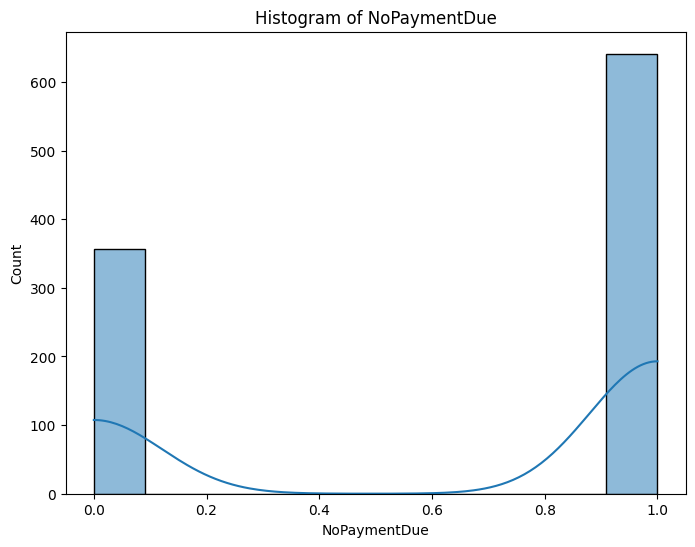

In [30]:
data_exploration(df_a1, 'NoPaymentDue') # Target variable is imbalanced
# Model accuracy must be greater than 0.64 to be considered better than the baseline model

### Generate Test Design

#### Data Splitting

In [31]:
# Split the data into training and testing sets - 70% training, 30% testing - Using stratified sampling
X = df_a1.drop('NoPaymentDue', axis=1)
y = df_a1['NoPaymentDue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666, stratify=y)

print("The length of training set:", len(X_train))
print("The length of testing  set:", len(y_test))

The length of training set: 698
The length of testing  set: 300


### SVM

In [32]:
# Train an SVM model with a linear kernel
svm_model = SVC(kernel='linear', random_state=666)
svm_model.fit(X_train, y_train)

# Make predictions using the SVM model
y_pred_svm = svm_model.predict(X_test)

# Evaluate the performance of the SVM model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_svm))

Confusion Matrix:
[[106   1]
 [  2 191]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       107
           1       0.99      0.99      0.99       193

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


Accuracy Score:
0.99


In [33]:
# Perform 5-fold cross-validation on the scaled data
cv_scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# Check for overfitting by comparing performance on the training and test sets
y_pred_train_svm = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train_svm)
test_accuracy = accuracy_score(y_test, y_pred_svm)

print("Training Set Accuracy:", train_accuracy)
print("Test Set Accuracy:", test_accuracy)

if train_accuracy > test_accuracy:
    difference = train_accuracy - test_accuracy
    print("The training accuracy is higher than test accuracy by", difference)
    if difference > 0.1:  # Arbitrary threshold, adjust as needed
        print("There might be overfitting")
    else:
        print("The difference is small, overfitting might not be an issue")
else:
    print("Overfitting is not an issue")

Cross-Validation Scores: [0.985      0.995      0.98       0.98492462 0.96984925]
Average Cross-Validation Score: 0.9829547738693467
Training Set Accuracy: 0.9856733524355301
Test Set Accuracy: 0.99
Overfitting is not an issue


Since we gain extremlly  high scores with SVM, we check the over fitting problem by using cross validation.
As it shows, there is no over fitting problem, so we will keep this model and see if the performance is consistent among different models.

### DECISION TREE

In [34]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, int(len(X_train)*0.03), int(len(X_train)*0.06)],
    'criterion': ['gini', 'entropy']
}

# Create the decision tree classifier model
dt_model = DecisionTreeClassifier(random_state=666)

# Create the grid search object
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Display the best hyperparameters found
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Get the best model from grid search
best_dt_model = grid_search.best_estimator_

Best Hyperparameters:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [35]:
# Create the decision tree classifier model
dt_model = DecisionTreeClassifier(random_state=666, **grid_search.best_params_)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test)

# Display the confusion matrix, classification report, and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_dt))

Confusion Matrix:
[[101   6]
 [  2 191]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       107
           1       0.97      0.99      0.98       193

    accuracy                           0.97       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300


Accuracy Score:
0.9733333333333334


The result looks good. We will check the structure of the tree if needed later.

### KNN

In [36]:
# Define the hyperparameter grid
param_grid = {'n_neighbors': list(range(1, 31))}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train)

print("Best Hyperparameters:")
print(knn_grid.best_params_)

Best Hyperparameters:
{'n_neighbors': 16}


In [37]:
# Get the best model from grid search
knn_model = KNeighborsClassifier(**knn_grid.best_params_)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Display the confusion matrix, classification report, and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_knn))

Confusion Matrix:
[[ 92  15]
 [ 44 149]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       107
           1       0.91      0.77      0.83       193

    accuracy                           0.80       300
   macro avg       0.79      0.82      0.80       300
weighted avg       0.83      0.80      0.81       300


Accuracy Score:
0.8033333333333333


KNN's performance can degrade in high-dimensional feature spaces, as the distance between points becomes less meaningful in higher dimensions.
Therefore, we think this is reason why KNN has a lower performance than SVM and Decision Tree.

### XGBOOST

We will experiment with an XGBoost Classifer in Sklearn.

In [38]:
# Train the XGB model
xgb_model = xgb.XGBClassifier(random_state=666) # Initialize xgboost classifier 

# Fit the model to the training data
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test) # Get predictions

# Evaluate the performance of the XGB Model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_xgb))

Confusion Matrix:
[[102   5]
 [  1 192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       107
           1       0.97      0.99      0.98       193

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300


Accuracy Score:
0.98


In [39]:
# Perform 5-fold cross-validation on the scaled data
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores_xgb)
print("Average Cross-Validation Score:", np.mean(cv_scores_xgb))

# Check for overfitting by comparing performance on the training and test sets
y_pred_train_xgb = xgb_model.predict(X_train)
train_accuracy_xgb = accuracy_score(y_train, y_pred_train_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("XGB Training Set Accuracy:", train_accuracy_xgb)
print("XGB Test Set Accuracy:", test_accuracy_xgb)

if train_accuracy_xgb > test_accuracy_xgb:
    difference_xgb = train_accuracy_xgb - test_accuracy_xgb
    print("The training accuracy is higher than test accuracy by", difference_xgb)
    if difference_xgb > 0.1:  # Arbitrary threshold, adjust as needed
        print("There might be overfitting")
    else:
        print("The difference is small, overfitting might not be an issue")
else:
    print("Overfitting is not an issue")


Cross-Validation Scores: [0.975      0.99       0.975      0.9798995  0.96984925]
Average Cross-Validation Score: 0.9779497487437185
XGB Training Set Accuracy: 1.0
XGB Test Set Accuracy: 0.98
The training accuracy is higher than test accuracy by 0.020000000000000018
The difference is small, overfitting might not be an issue


Because the difference is by 0.02, overfitting might not be an issue, so we'll keep this model.

### Naive Bayes

In [40]:
mnb_model = MultinomialNB(fit_prior = False, alpha = 0.01)

# Train the model
mnb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_mnb = mnb_model.predict(X_test)

# Display the confusion matrix, classification report, and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mnb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mnb))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_mnb))

Confusion Matrix:
[[101   6]
 [  9 184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       107
           1       0.97      0.95      0.96       193

    accuracy                           0.95       300
   macro avg       0.94      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300


Accuracy Score:
0.95


It is suprising that Naive Bayes has a good performance as fit_prior is set to False when the target variable is imbalanced.

### MLP

In [41]:
# Function to create a Keras model with specified hyperparameters
def create_model(optimizer='adam', neurons=32, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],))) # dim is 35
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model with the KerasClassifier
model_mlp = KerasClassifier(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'neurons': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100]
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model_mlp , param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3)

# Fit the grid search to the data
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_result.best_params_)

Best Hyperparameters:
{'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'neurons': 128, 'optimizer': 'adam'}


In [42]:
# Create the best model based on the grid search with further manual tuning
mlp_model = Sequential()
mlp_model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(1, activation='sigmoid'))

mlp_model.compile(optimizer=keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
mlp_model.fit(X_train, y_train, validation_split=0.33, batch_size=32, epochs=100, verbose=0)

y_pred_mlp = mlp_model.predict(X_test, verbose=0)

# Print the results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp.round())) # round() to convert probabilities to 0/1

print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp.round()))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_mlp.round()))

Confusion Matrix:
[[100   7]
 [  1 192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       107
           1       0.96      0.99      0.98       193

    accuracy                           0.97       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300


Accuracy Score:
0.9733333333333334


It is such a compuationally expensive model. And the accuracy is not as good as SVM and Decision Tree. 

### Random Forest

In [43]:
# Create a Random Forest Classifier
model_rf = RandomForestClassifier(random_state=666)

# Define the random search parameters
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model_rf, param_distributions=param_dist, scoring='accuracy', n_iter=50, n_jobs=-1, cv=3, random_state=666)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(random_search.best_params_)

# Evaluate the best model on the test set
rf_model = random_search.best_estimator_
y_pred_rf = rf_model.predict(X_test)

# Print the results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_rf))

Best Hyperparameters:
{'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 130}
Confusion Matrix:
[[101   6]
 [  2 191]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       107
           1       0.97      0.99      0.98       193

    accuracy                           0.97       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300


Accuracy Score:
0.9733333333333334


### Logistic Regression

In [44]:
# Train a Logistic Regression model 
lr_model = LogisticRegression(C=30, penalty='l2',max_iter=100,solver='liblinear', random_state=666)
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Print the results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_lr))

Confusion Matrix:
[[107   0]
 [  1 192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       107
           1       1.00      0.99      1.00       193

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Accuracy Score:
0.9966666666666667


In [45]:
# Perform 5-fold cross-validation on the scaled data
cv_scores = cross_val_score(lr_model, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))

# Check for overfitting by comparing performance on the training and test sets
y_pred_train_lr = lr_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train_lr)
test_accuracy = accuracy_score(y_test, y_pred_lr)

print("Training Set Accuracy:", train_accuracy)
print("Test Set Accuracy:", test_accuracy)

if train_accuracy > test_accuracy:
    difference = train_accuracy - test_accuracy
    print("The training accuracy is higher than test accuracy by", difference)
    if difference > 0.1:  # Arbitrary threshold, adjust as needed
        print("There might be overfitting")
    else:
        print("The difference is small, overfitting might not be an issue")
else:
    print("Overfitting is not an issue")

Cross-Validation Scores: [0.985      0.995      0.985      0.98492462 0.9798995 ]
Average Cross-Validation Score: 0.9859648241206032
Training Set Accuracy: 0.994269340974212
Test Set Accuracy: 0.9966666666666667
Overfitting is not an issue


## Assess Models

In [46]:
# define a function to get metrics
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # If the model is a Keras model (Sequential)
    if isinstance(model, keras.Sequential): # for mlp
        y_probs = model.predict(X_test, verbose=0)
        y_pred = y_probs.round().ravel() # convert probabilities to 0/1
        
    elif hasattr(model, "predict_proba"): 
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.decision_function(X_test) # for svm, dt

    # Calculate metrics
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    auc_roc = round(roc_auc_score(y_test, y_probs), 4)

    # Calculate the lift value at 2nd decile (20%)
    lift_table = kds.metrics.decile_table(y_test, y_pred.round(),labels=False)
    lift_table['lift_value'] = (lift_table['cum_resp_pct'] - lift_table['cum_cust_pct'])/(lift_table['cum_resp_pct_wiz'] - lift_table['cum_cust_pct'])
    sec_lift_score = lift_table[lift_table['decile'] == 2]['lift_value'].values[0]

    # calculate the stability
    if np.all(np.diff(lift_table.loc[:2, 'resp_rate']) <= 0) == True: # if the response rate is decreasing monotonically until second decile, the model is stable
        stab_score = 1
    else:
        stab_score = 0

    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1": f1, "AUC_ROC": auc_roc, "Lift_Score": sec_lift_score, "Stability": stab_score}

In [47]:
svm_metrics = get_metrics(svm_model, X_test, y_test)
dt_metrics = get_metrics(dt_model, X_test, y_test)
knn_metrics = get_metrics(knn_model, X_test, y_test)
xgb_metrics = get_metrics(xgb_model, X_test, y_test)
mnb_metrics = get_metrics(mnb_model, X_test, y_test)
mlp_metrics = get_metrics(mlp_model, X_test, y_test)
rf_metrics = get_metrics(rf_model, X_test, y_test)
lr_metrics = get_metrics(lr_model, X_test, y_test)

10/10 [==============================] - 0s 2ms/step


In [48]:
# Create a list of dictionaries containing model names and their metrics
all_metrics = [
    {"Model": "SVM", **svm_metrics},
    {"Model": "DT", **dt_metrics},
    {"Model": "KNN", **knn_metrics},
    {"Model": "XGB", **xgb_metrics},
    {"Model": "MNB", **mnb_metrics},
    {"Model": "MLP", **mlp_metrics},
    {"Model": "RF", **rf_metrics},
    {"Model": "LR", **lr_metrics}
]

# Convert the list of dictionaries into DataFrame
metrics_df = pd.DataFrame(all_metrics)

metrics_df

,Model,Accuracy,Precision,Recall,F1,AUC_ROC,Lift_Score,Stability
0,SVM,0.9900,0.9948,0.9896,0.9922,0.9996,1.000000,1
1,DT,0.9733,0.9695,0.9896,0.9795,0.9964,0.906566,1
2,KNN,0.8033,0.9085,0.7720,0.8347,0.8687,0.766324,0
3,XGB,0.9800,0.9746,0.9948,0.9846,0.9997,0.859848,0
4,MNB,0.9500,0.9684,0.9534,0.9608,0.9888,0.813131,0
5,MLP,0.9733,0.9648,0.9948,0.9796,0.9984,0.953283,0
6,RF,0.9733,0.9695,0.9896,0.9795,0.9983,0.906566,0
7,LR,0.9967,1.0000,0.9948,0.9974,1.0000,1.000000,1


### Lift Check for Yuri
Lift at the 3rd decile

In [49]:
# Create function for calculating lift for all models
def lift_cal(y_pred, decile):
  lift_table = kds.metrics.decile_table(y_test, y_pred.round())
  lift_table['lift_value'] = (lift_table['cum_resp_pct'] - lift_table['cum_cust_pct'])/(lift_table['cum_resp_pct_wiz'] - lift_table['cum_cust_pct'])
  third_lift_value = lift_table[lift_table['decile'] == decile]['lift_value'].values[0]
  print(lift_table)
  print('-----------------------')
  print('The lift value of decile_%1i is %4.3f.' %(decile, third_lift_value))
  return lift_table

In [50]:
lift_table_svm = lift_cal(y_pred_svm, 3)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

In [51]:
lift_table_dt = lift_cal(y_pred_dt, 3)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

In [52]:
lift_table_knn = lift_cal(y_pred_knn, 3)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

In [53]:
lift_table_xgb = lift_cal(y_pred_xgb, 3)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

In [54]:
lift_table_mnb = lift_cal(y_pred_mnb, 3)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

In [55]:
lift_table_mlp = lift_cal(y_pred_mlp, 3)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

In [56]:
lift_table_rf = lift_cal(y_pred_rf, 3)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

In [57]:
lift_table_lr = lift_cal(y_pred_lr, 3)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

# Task A4:
After reviewing the outputs of the previous tasks, some of the end-user experts remarked that it might also be useful to incorporate the fact that it was more costly to misclassify a person from whom a payment was really due than to misclassify a person from whom no payment was due. Ms. Imani Kuhn suggested that they should research the relevant costs.

The result of their research was that there were an:
* average profit of 817.00 for correctly classifying a person for whom a  payment was really due
* average profit of 245.00 for correctly classifying a person for whom no payment was really due
* average loss of 671.00 for misclassifying a person for whom
a payment was really due
* average loss of 465.00 for misclassifying a person for whom no payment was really due

The target event is NoPaymentDue = ‘pos’.

In [135]:
# Create profit and loss values
profit_TP = 817
profit_TN = 245
loss_FP = 671
loss_FN = 465

# Create AVG Worst Profit
avg_worst_profit = loss_FP*0 + loss_FN*0

## SVM

In [169]:
svm_matrix_table = pd.DataFrame(confusion_matrix(y_test, y_pred_svm),
             columns=['Predicted Pos', 'Predicted Neg'],
             index=['True Pos', 'True Neg']
)

svm_matrix_table

,Predicted Pos,Predicted Neg
True Pos,106,1
True Neg,2,191


In [170]:
# Define True Positive, True Negative, False Positive, and False Negative
TP = svm_matrix_table.iloc[0][0] # Index of the number of loan cases misclassified as Neg
TN = svm_matrix_table.iloc[1][1] # Index of the number of loan cases misclassified as Pos
FP = svm_matrix_table.iloc[0][1] # Index of the number of loan cases misclassified as Neg
FN = svm_matrix_table.iloc[1][0] # Index of the number of loan cases misclassified as Pos

In [171]:
# Calculate Best Possible Profit
svm_bpp = (TP*profit_TP + TN*profit_TN)
print(svm_bpp)

# Calculate AVG Best Possible Profit
svm_avg_bpp = svm_bpp/len(y_test)
print(svm_avg_bpp)

# Calculate Profit
svm_profit = (TP*profit_TP + TN*profit_TN) - (FP*loss_FP + FN*loss_FN)
print(svm_profit)

# Calculate AVG Profit per case
svm_avg_profit = svm_profit/len(y_test)
print(svm_avg_profit)

# Calculate normalized score
svm_score = (svm_avg_profit - avg_worst_profit)/(svm_avg_bpp - avg_worst_profit)
print(svm_score)

133397
444.6566666666667
131796
439.32
0.9879982308447716


## DT

In [172]:
dt_matrix_table = pd.DataFrame(confusion_matrix(y_test, y_pred_dt),
             columns=['Predicted Pos', 'Predicted Neg'],
             index=['True Pos', 'True Neg']
)

dt_matrix_table

,Predicted Pos,Predicted Neg
True Pos,101,6
True Neg,2,191


In [173]:
# Define True Positive, True Negative, False Positive, and False Negative
TP = dt_matrix_table.iloc[0][0] # Index of the number of loan cases misclassified as Neg
TN = dt_matrix_table.iloc[1][1] # Index of the number of loan cases misclassified as Pos
FP = dt_matrix_table.iloc[0][1] # Index of the number of loan cases misclassified as Neg
FN = dt_matrix_table.iloc[1][0] # Index of the number of loan cases misclassified as Pos

In [174]:
# Calculate Best Possible Profit
dt_bpp = (TP*profit_TP + TN*profit_TN)
print(dt_bpp)

# Calculate AVG Best Possible Profit
dt_avg_bpp = dt_bpp/len(y_test)
print(dt_avg_bpp)

# Calculate Profit
dt_profit = (TP*profit_TP + TN*profit_TN) - (FP*loss_FP + FN*loss_FN)
print(dt_profit)

# Calculate AVG Profit per case
dt_avg_profit = dt_profit/len(y_test)
print(dt_avg_profit)

# Calculate normalized score
dt_score = (dt_avg_profit - avg_worst_profit)/(dt_avg_bpp - avg_worst_profit)
print(dt_score)

129312
431.04
124356
414.52
0.9616740905716405


## KNN

In [175]:
knn_matrix_table = pd.DataFrame(confusion_matrix(y_test, y_pred_knn),
             columns=['Predicted Pos', 'Predicted Neg'],
             index=['True Pos', 'True Neg']
)

knn_matrix_table

,Predicted Pos,Predicted Neg
True Pos,92,15
True Neg,44,149


In [176]:
# Define True Positive, True Negative, False Positive, and False Negative
TP = knn_matrix_table.iloc[0][0] # Index of the number of loan cases misclassified as Neg
TN = knn_matrix_table.iloc[1][1] # Index of the number of loan cases misclassified as Pos
FP = knn_matrix_table.iloc[0][1] # Index of the number of loan cases misclassified as Neg
FN = knn_matrix_table.iloc[1][0] # Index of the number of loan cases misclassified as Pos

In [177]:
# Calculate Best Possible Profit
knn_bpp = (TP*profit_TP + TN*profit_TN)
print(knn_bpp)

# Calculate AVG Best Possible Profit
knn_avg_bpp = knn_bpp/len(y_test)
print(knn_avg_bpp)

# Calculate Profit
knn_profit = (TP*profit_TP + TN*profit_TN) - (FP*loss_FP + FN*loss_FN)
print(knn_profit)

# Calculate AVG Profit per case
knn_avg_profit = knn_profit/len(y_test)
print(knn_avg_profit)

# Calculate normalized score
knn_score = (knn_avg_profit - avg_worst_profit)/(knn_avg_bpp - avg_worst_profit)
print(knn_score)

111669
372.23
81144
270.48
0.7266475028879994


## XGBOOST

In [178]:
xgb_matrix_table = pd.DataFrame(confusion_matrix(y_test, y_pred_xgb),
             columns=['Predicted Pos', 'Predicted Neg'],
             index=['True Pos', 'True Neg']
)

xgb_matrix_table

,Predicted Pos,Predicted Neg
True Pos,102,5
True Neg,1,192


In [179]:
# Define True Positive, True Negative, False Positive, and False Negative
TP = xgb_matrix_table.iloc[0][0] # Index of the number of loan cases misclassified as Neg
TN = xgb_matrix_table.iloc[1][1] # Index of the number of loan cases misclassified as Pos
FP = xgb_matrix_table.iloc[0][1] # Index of the number of loan cases misclassified as Neg
FN = xgb_matrix_table.iloc[1][0] # Index of the number of loan cases misclassified as Pos

In [180]:
# Calculate Best Possible Profit
xgb_bpp = (TP*profit_TP + TN*profit_TN)
print(xgb_bpp)

# Calculate AVG Best Possible Profit
xgb_avg_bpp = xgb_bpp/len(y_test)
print(xgb_avg_bpp)

# Calculate Profit
xgb_profit = (TP*profit_TP + TN*profit_TN) - (FP*loss_FP + FN*loss_FN)
print(xgb_profit)

# Calculate AVG Profit per case
xgb_avg_profit = xgb_profit/len(y_test)
print(xgb_avg_profit)

# Calculate normalized score
xgb_score = (xgb_avg_profit - avg_worst_profit)/(xgb_avg_bpp - avg_worst_profit)
print(xgb_score)

130374
434.58
126554
421.8466666666667
0.9706996793839263


## MNB

In [181]:
mnb_matrix_table = pd.DataFrame(confusion_matrix(y_test, y_pred_mnb),
             columns=['Predicted Pos', 'Predicted Neg'],
             index=['True Pos', 'True Neg']
)

mnb_matrix_table

,Predicted Pos,Predicted Neg
True Pos,101,6
True Neg,9,184


In [182]:
# Define True Positive, True Negative, False Positive, and False Negative
TP = mnb_matrix_table.iloc[0][0] # Index of the number of loan cases misclassified as Neg
TN = mnb_matrix_table.iloc[1][1] # Index of the number of loan cases misclassified as Pos
FP = mnb_matrix_table.iloc[0][1] # Index of the number of loan cases misclassified as Neg
FN = mnb_matrix_table.iloc[1][0] # Index of the number of loan cases misclassified as Pos

In [183]:
# Calculate Best Possible Profit
mnb_bpp = (TP*profit_TP + TN*profit_TN)
print(mnb_bpp)

# Calculate AVG Best Possible Profit
mnb_avg_bpp = mnb_bpp/len(y_test)
print(mnb_avg_bpp)

# Calculate Profit
mnb_profit = (TP*profit_TP + TN*profit_TN) - (FP*loss_FP + FN*loss_FN)
print(mnb_profit)

# Calculate AVG Profit per case
mnb_avg_profit = mnb_profit/len(y_test)
print(mnb_avg_profit)

# Calculate normalized score
mnb_score = (mnb_avg_profit - avg_worst_profit)/(mnb_avg_bpp - avg_worst_profit)
print(mnb_score)

127597
425.3233333333333
119386
397.9533333333333
0.9356489572638855


## MLP

In [184]:
mlp_matrix_table = pd.DataFrame(confusion_matrix(y_test, y_pred_mlp.round()),
             columns=['Predicted Pos', 'Predicted Neg'],
             index=['True Pos', 'True Neg']
)

mlp_matrix_table

,Predicted Pos,Predicted Neg
True Pos,100,7
True Neg,1,192


In [185]:
# Define True Positive, True Negative, False Positive, and False Negative
TP = mlp_matrix_table.iloc[0][0] # Index of the number of loan cases misclassified as Neg
TN = mlp_matrix_table.iloc[1][1] # Index of the number of loan cases misclassified as Pos
FP = mlp_matrix_table.iloc[0][1] # Index of the number of loan cases misclassified as Neg
FN = mlp_matrix_table.iloc[1][0] # Index of the number of loan cases misclassified as Pos

In [186]:
# Calculate Best Possible Profit
mlp_bpp = (TP*profit_TP + TN*profit_TN)
print(mlp_bpp)

# Calculate AVG Best Possible Profit
mlp_avg_bpp = mlp_bpp/len(y_test)
print(mlp_avg_bpp)

# Calculate Profit
mlp_profit = (TP*profit_TP + TN*profit_TN) - (FP*loss_FP + FN*loss_FN)
print(mlp_profit)

# Calculate AVG Profit per case
mlp_avg_profit = mlp_profit/len(y_test)
print(mlp_avg_profit)

# Calculate normalized score
mlp_score = (mlp_avg_profit - avg_worst_profit)/(mlp_avg_bpp - avg_worst_profit)
print(mlp_score)

128740
429.1333333333333
123578
411.9266666666667
0.9599036818393663


## RF

In [187]:
rf_matrix_table = pd.DataFrame(confusion_matrix(y_test, y_pred_rf),
             columns=['Predicted Pos', 'Predicted Neg'],
             index=['True Pos', 'True Neg']
)

rf_matrix_table

,Predicted Pos,Predicted Neg
True Pos,101,6
True Neg,2,191


In [188]:
# Define True Positive, True Negative, False Positive, and False Negative
TP = rf_matrix_table.iloc[0][0] # Index of the number of loan cases misclassified as Neg
TN = rf_matrix_table.iloc[1][1] # Index of the number of loan cases misclassified as Pos
FP = rf_matrix_table.iloc[0][1] # Index of the number of loan cases misclassified as Neg
FN = rf_matrix_table.iloc[1][0] # Index of the number of loan cases misclassified as Pos

In [189]:
# Calculate Best Possible Profit
rf_bpp = (TP*profit_TP + TN*profit_TN)
print(rf_bpp)

# Calculate AVG Best Possible Profit
rf_avg_bpp = rf_bpp/len(y_test)
print(rf_avg_bpp)

# Calculate Profit
rf_profit = (TP*profit_TP + TN*profit_TN) - (FP*loss_FP + FN*loss_FN)
print(rf_profit)

# Calculate AVG Profit per case
rf_avg_profit = rf_profit/len(y_test)
print(rf_avg_profit)

# Calculate normalized score
rf_score = (rf_avg_profit - avg_worst_profit)/(rf_avg_bpp - avg_worst_profit)
print(rf_score)

129312
431.04
124356
414.52
0.9616740905716405


## LR

In [190]:
lr_matrix_table = pd.DataFrame(confusion_matrix(y_test, y_pred_lr),
             columns=['Predicted Pos', 'Predicted Neg'],
             index=['True Pos', 'True Neg']
)

lr_matrix_table

,Predicted Pos,Predicted Neg
True Pos,107,0
True Neg,1,192


In [191]:
# Define True Positive, True Negative, False Positive, and False Negative
TP = lr_matrix_table.iloc[0][0] # Index of the number of loan cases misclassified as Neg
TN = lr_matrix_table.iloc[1][1] # Index of the number of loan cases misclassified as Pos
FP = lr_matrix_table.iloc[0][1] # Index of the number of loan cases misclassified as Neg
FN = lr_matrix_table.iloc[1][0] # Index of the number of loan cases misclassified as Pos

In [192]:
# Calculate Best Possible Profit
lr_bpp = (TP*profit_TP + TN*profit_TN)
print(lr_bpp)

# Calculate AVG Best Possible Profit
lr_avg_bpp = rf_bpp/len(y_test)
print(lr_avg_bpp)

# Calculate Profit
lr_profit = (TP*profit_TP + TN*profit_TN) - (FP*loss_FP + FN*loss_FN)
print(lr_profit)

# Calculate AVG Profit per case
lr_avg_profit = lr_profit/len(y_test)
print(lr_avg_profit)

# Calculate normalized score
lr_score = (lr_avg_profit - avg_worst_profit)/(lr_avg_bpp - avg_worst_profit)
print(lr_score)

134459
431.04
133994
446.64666666666665
1.0362070032170254


In [193]:
print('SVM:', svm_bpp, svm_avg_bpp, svm_profit, svm_avg_profit, svm_score)
print('DT:', dt_bpp, dt_avg_bpp, dt_profit, dt_avg_profit, dt_score)
print('KNN:', knn_bpp, knn_avg_bpp, knn_profit, knn_avg_profit, knn_score)
print('XGB:', xgb_bpp, xgb_avg_bpp, xgb_profit, xgb_avg_profit, xgb_score)
print('MNB:', mnb_bpp, mnb_avg_bpp, mnb_profit, mnb_avg_profit, mnb_score)
print('MLP:', mlp_bpp, mlp_avg_bpp, mlp_profit, mlp_avg_profit, mlp_score)
print('RF:', rf_bpp, rf_avg_bpp, rf_profit, rf_avg_profit, rf_score)
print('LR:', lr_bpp, lr_avg_bpp, lr_profit, lr_avg_profit, lr_score)

SVM: 133397 444.6566666666667 131796 439.32 0.9879982308447716
DT: 129312 431.04 124356 414.52 0.9616740905716405
KNN: 111669 372.23 81144 270.48 0.7266475028879994
XGB: 130374 434.58 126554 421.8466666666667 0.9706996793839263
MNB: 127597 425.3233333333333 119386 397.9533333333333 0.9356489572638855
MLP: 128740 429.1333333333333 123578 411.9266666666667 0.9599036818393663
RF: 129312 431.04 124356 414.52 0.9616740905716405
LR: 134459 431.04 133994 446.64666666666665 1.0362070032170254
